In [95]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse as ph

plt.style.use('ggplot')
sns.set(rc={'figure.figsize': (12, 4)}, style="whitegrid")

Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [96]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [97]:
groups.dtypes

id      int64
grp    object
dtype: object

In [98]:
groups.shape

(74484, 2)

In [99]:
# проверяем количестов уникальных пользователей
groups.id.nunique()

74484

In [100]:
group_add = pd.read_csv('Проект_2_group_add.csv', sep=',')
group_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [101]:
group_add.shape

(92, 2)

In [102]:
# дополняем файл информацией, которую получили через 2 дня
groups  = pd.concat([groups, group_add], ignore_index=True)
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [103]:
groups.shape

(74576, 2)

In [104]:
# проверяем количество уникальных пользователей
groups.id.nunique()

74576

Делаем вывод, что все дополнительный датафрейм не имеет дубликатов и мы просто добавили новых пользователей, участников эксперимента.

In [105]:
active_studs = pd.read_csv('Проект_2_active_studs.csv')
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [106]:
active_studs.dtypes

student_id    int64
dtype: object

In [107]:
active_studs.shape

(8341, 1)

In [108]:
# переименовываем столбец для merge (т.к. пользователи и студенты имеют одни id).Объединяем таблицы 
# active_studs и groups. И выделяем участников эксперимента. 
groups = groups.rename(columns={'id': 'student_id'})
active_studs_check = active_studs.merge(groups, how='left', on='student_id')
active_studs_check.head(3)

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B


In [109]:
active_studs_check.shape

(8341, 2)

In [110]:
checks = pd.read_csv('Проект_2_checks.csv', sep=';')
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [111]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [112]:
checks.shape

(541, 2)

In [113]:
# объединяем датафреймы с данными о студентах участвующих в эксперименте и оплатах
active_studs_check = active_studs_check.merge(checks, how='left', on='student_id')
active_studs_check.head()

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


In [114]:
active_studs_check.shape

(8341, 3)

In [115]:
# поменяем значение NaN на 0, так как фактически это обозначает, 
# что студент не внес оплату за обучение и не воспользовался механизмом оплаты
active_studs_check['rev'] = active_studs_check['rev'].fillna(0)
active_studs_check.head(3)

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0


In [116]:
# посмотрим на конверсию внутри групп
active_studs_check.groupby('grp', as_index=False).agg({'student_id': 'count'})

,grp,student_id
0,A,1538
1,B,6803


In [117]:
CR_control = active_studs_check.query("grp == 'A' and rev > 0").agg({'student_id': 'count'}) / 1538
CR_control

student_id    0.050715
dtype: float64

In [118]:
CR_test = active_studs_check.query("grp == 'B' and rev > 0").agg({'student_id': 'count'}) / 6803
CR_test

student_id    0.046156
dtype: float64


1.На какие метрики Вы смотрите в ходе анализа и почему?
Мы имеем датафрейм с пользователями, которые видели два варианта механики оплаты услуг на сайте. Будем анализировать тех пользователей, которые стали студентами, т.к. только активные пользователи могут видеть механизм оплаты. Основной метрикой будем считать среднюю сумму покупки.

Конверсия оплативших студентов незначительно различается и выборка очень небольшая, ее мы оценивать не будем. Очевидно, что новая механика оплаты больше направлена на увеличение средней суммы оплаты. Поэтому формулируем нулевую гипотезу следующим образом.

Нулевая гипотеза Н0: различия между механикой оплаты нет 

и альтернативная гипотеза

H1: новая механика оплаты на сайте влияет на средную сумму оплат студентами.

In [119]:
# формируем отдельно данные тестовой и контрольной группы, чтобы оценить нормальность визуально
test = active_studs_check.query("grp == 'B'").rev
control = active_studs_check.query("grp == 'A'").rev

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


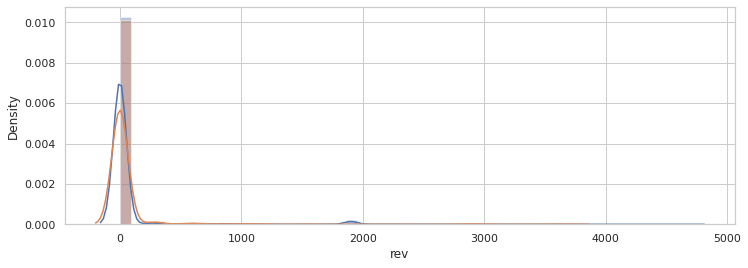

In [120]:
sns.distplot(test)
sns.distplot(control)

Визуально по графикам можно сделать вывод, что распределение не выглядит равномерным,также сами выборки не являются равными по количеству пользователей. Поэтому будем  использовать метод BOOTSTRAP для оценивая статистической гипотезы.

In [121]:
def get_bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it):
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
        # mean() - применяем статистику
        
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2   
       
    return {"p_value": p_value}

In [122]:
x = active_studs_check['rev'][(active_studs_check['grp'] == 'A')]
y = active_studs_check['rev'][(active_studs_check['grp'] == 'B')]

for i in range(10):
    res_b_npmean = get_bootstrap(x, y)
        
    print(f'Boot mean: {res_b_npmean["p_value"]}')

Boot mean: 0.03489016972421875
Boot mean: 0.04463164051699688
Boot mean: 0.025885008150788622
Boot mean: 0.038540302685138014
Boot mean: 0.04017613809916934
Boot mean: 0.03513998751834858
Boot mean: 0.04589972846710404
Boot mean: 0.03728665126252193
Boot mean: 0.040794349522250105
Boot mean: 0.03894926127606028


Выводы:

Различия являются статистически значеными (p-value <0.05) и гипотеза о том, что новый механизм оплаты влияет на среднюю стоимость оплат студентов с вероятностью 95% может быть принята. 

Также мы видим, что произошло увеличиение средней стоимсти оплат. И это позволяет принять решение о том, что следует применить данную механику оплаты по всем пользователям.

Посмотрим, также как изменились показатели средней суммы оплаты студентов.

In [123]:
# средняя стоимость оплат студентов в контрольной группе
active_studs_check.query('grp == "A"').rev.mean().round(2)

47.35

In [124]:
# средняя стоимость оплат студентов в тестовой группе
active_studs_check.query('grp == "B"').rev.mean().round(2)

58.06

In [125]:
# процент увеличение средней стоимости оплат.
((active_studs_check.query('grp == "B"').rev.mean().round(2)/active_studs_check.query('grp == "A"')
.rev.mean().round(2) - 1) * 100).round(2)

22.62

Задание 2. SQL
2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [126]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

In [127]:
# создаем запрос, db автоматически заменится на значение из database
q = """
SELECT
st_id,
COUNT(correct) AS goroshin_month

FROM peas
WHERE 
    correct = 1
GROUP By 
    st_id,
    toStartOfMonth(timest)
HAVING
    goroshin_month >= 20
    """

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,st_id,goroshin_month
0,510283,23
1,370846,34
2,43985,28
3,335446,45
4,899745,45
...,...,...
131,61717,21
132,98637,40
133,471168,28
134,969749,31


In [128]:
# проверим все ли студенты являются уникальных.
q_test.st_id.nunique()

136

Вывод: КОЛИЧЕСТВО УСЕРДНЫХ СТУДЕНТОВ 136 ЧЕЛОВЕК

2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 

ARPAU 

CR в покупку 

СR активного пользователя в покупку 

CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [129]:
# создаем запрос, db автоматически заменится на значение из database
q = """
SELECT
a.test_grp as test_grp,
a.CR as CR,
b.APRU as ARPU,
c.ARPAU as ARPAU,
c.CR_ACTIV as CR_ACTIV,
d.CR_ACTIV_MATH as CR_ACTIV_MATH
FROM
    (
    SELECT 
    test_grp,
    (count(DISTINCT r.st_id)-1)/ count(DISTINCT st_id)*100 AS CR
    FROM 
    studs as l
    LEFT JOIN
        final_project_check as r 
        ON
        l.st_id =  r.st_id
    GROUP BY test_grp
    ) as a
LEFT JOIN
    (
    SELECT
      test_grp,
     AVG (money) AS APRU
     FROM 
        (SELECT
            l.st_id,
            l.test_grp,
            r.money as money
        FROM
            studs as l
        LEFT JOIN
            (
            SELECT
                st_id,
                SUM(money) as money
            FROM final_project_check
            GROUP BY st_id
            ) as r
        ON  
        l.st_id = r.st_id
            )
    GROUP BY
        test_grp
    ) as b
ON a.test_grp = b.test_grp

LEFT JOIN
    (
        SELECT
     test_grp,
     AVG (sum_buy) AS ARPAU,
     (count(DISTINCT r2.st_id)-1)/ count(DISTINCT l.st_id)*100 AS CR_ACTIV
     FROM
        (
        SELECT 
        st_id,
        sum(correct) AS goroshin_month
        FROM peas
        GROUP By 
            st_id
        HAVING
            goroshin_month > 10
        ) as l
    LEFT JOIN
        studs as r1
        ON
            l.st_id =  r1.st_id
    LEFT JOIN
        (
        SELECT
        st_id,
        SUM(money) as sum_buy
        FROM final_project_check
        GROUP BY st_id
        ) as r2
        ON
            l.st_id =  r2.st_id
    GROUP BY test_grp        
    ) as c
ON a.test_grp = c.test_grp

LEFT JOIN
    (
        SELECT
        test_grp,
        (count(DISTINCT r2.st_id)-1)/ count(DISTINCT l.st_id)*100 AS CR_ACTIV_MATH
        FROM
            (
            SELECT
            st_id,
            sum(correct) AS goroshin_math
            FROM peas
            WHERE subject = 'Math'
            GROUP BY st_id
            HAVING goroshin_math >= 2
            ) as l
        LEFT JOIN
            studs as r1
            ON
                l.st_id =  r1.st_id
        LEFT JOIN
            (
            SELECT
            st_id,
            SUM(money) as sum_buy
            FROM final_project_check
            WHERE subject = 'Math'
            GROUP BY st_id
            ) as r2
            ON
                l.st_id =  r2.st_id
        GROUP BY test_grp
    ) as d
ON a.test_grp = d.test_grp

    """

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,test_grp,CR,ARPU,ARPAU,CR_ACTIV,CR_ACTIV_MATH
0,control,4.918033,4540.983607,10393.700787,11.023622,6.122449
1,pilot,10.847458,11508.474576,29739.583333,26.041667,9.523810


Задание 3. Python

3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [130]:
# Берем как первоночальный файл groups.csv из первого задания. Предпологаем, что он уже существует.
groups = pd.read_csv('Проект_2_groups.csv', sep=';')

In [131]:
while True:
    group_add = pd.read_csv('Проект_2_group_add.csv', sep=',')
    print(group_add)
    time.sleep(3600) #файл будет выгружаться повторно через 1 час

           id grp
0     5694584   B
1     5694830   B
2     5695057   B
3     5698872   B
4     5699067   B
..        ...  ..
87  200247820   B
88  201032527   B
89  201067612   B
90  201067653   B
91  201067659   B

[92 rows x 2 columns]


KeyboardInterrupt: 

In [132]:
#пишем функцию, которая будет считать метрики для обновленного файла
def gr_add(group_add_1, groups_1):
    # сохраняем старый датафрейм для построения сравнительных графиков
    groups_OLD = groups_1
    # загружаем файлы с дополнительными параметрами
    active_studs = pd.read_csv('Проект_2_active_studs.csv')
    checks = pd.read_csv('Проект_2_checks.csv', sep=';')
    
    # соединяем два выгруженных файла без учета совподения названия заголовков при помощи перевода в массивы
    grops_NEW = pd.DataFrame(np.split(np.concatenate((groups_OLD.values.ravel(), group_add.values.ravel())),
    len(np.concatenate((groups_OLD.values.ravel(), group_add.values.ravel()))) / 2))
    grops_NEW.columns = ['student_id', 'grp']   

    groups_OLD = groups_OLD.rename(columns={'id': 'student_id'})
    # добавляем дополнительные параметры к старой таблице
    active_studs_check_OLD = active_studs.merge(groups_OLD, how='left', on='student_id')
    active_studs_check_OLD = active_studs_check_OLD.merge(checks, how='left', on='student_id')
    active_studs_check_OLD['rev'] = active_studs_check_OLD['rev'].fillna(0)
    active_studs_check_OLD = active_studs_check_OLD.dropna()

    # добавляем дополнительные параметры к новой таблице
    active_studs_check_NEW = active_studs.merge(grops_NEW, how='left', on= 'student_id')
    active_studs_check_NEW = active_studs_check_NEW.merge(checks, how='left', on='student_id')
    active_studs_check_NEW['rev'] = active_studs_check_NEW['rev'].fillna(0)
    active_studs_check_NEW = active_studs_check_NEW.dropna()

    # создаем файл для подсчета основных метрик в старой и новой таблицах
    data = pd.DataFrame({
    'groups': ['OLD', 'NEW'], 
    'unique_id': [groups_OLD.student_id.nunique(), grops_NEW.student_id.nunique()],
    'CR': [active_studs_check_OLD.query("rev > 0").rev.count() / active_studs_check_OLD.rev.count() * 100,
    active_studs_check_NEW.query("rev > 0").rev.count() / active_studs_check_NEW.rev.count() * 100],
    'ARPU': [active_studs_check_OLD.rev.mean(), active_studs_check_NEW.rev.mean()],
    'ARPAU': [active_studs_check_OLD.query("rev > 0").rev.mean(), 
    active_studs_check_NEW.query("rev > 0").rev.mean()]
                            })
    return data

In [133]:
data = gr_add(group_add,groups)

In [134]:
data.style.hide_index().set_caption('ОСНОВНЫЕ МЕТРИКИ')

groups,unique_id,CR,ARPU,ARPAU
OLD,74484,4.695005,55.943084,1191.544766
NEW,74576,4.699676,56.083683,1193.352050


2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [135]:
def grafic(data_1):
    i = 1
    while i < 5:
        name = data_1.columns
        plt.figure(figsize=(12, 17))
        fig = plt.subplot(4, 1, i)
        print (sns.barplot(x=np.array(data_1.iloc[:, [0]]).ravel(), y=np.array(data_1.iloc[:, [i]]).ravel()))
        plt.title(name[i], fontsize=15)
        i += 1

AxesSubplot(0.125,0.71587;0.775x0.16413)
AxesSubplot(0.125,0.518913;0.775x0.16413)
AxesSubplot(0.125,0.321957;0.775x0.16413)
AxesSubplot(0.125,0.125;0.775x0.16413)


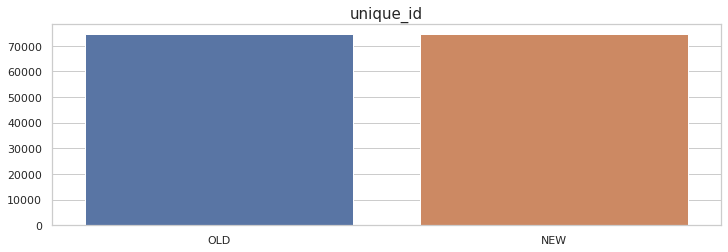

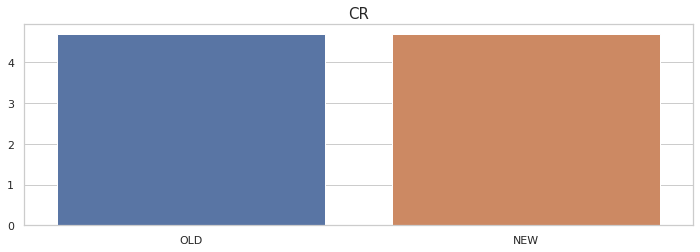

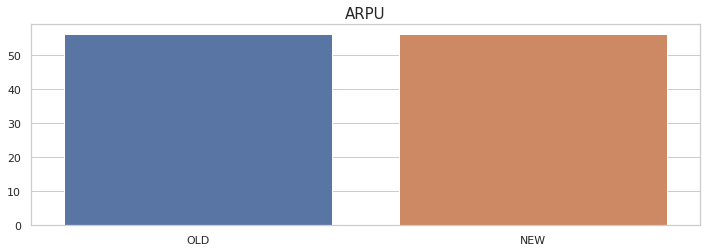

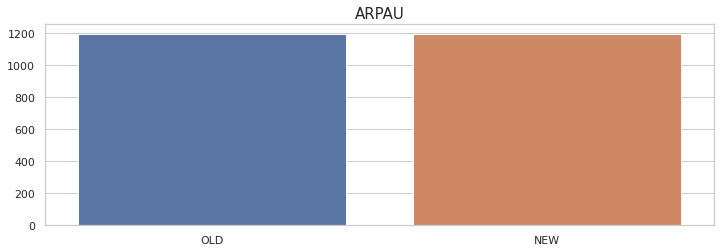

In [136]:
grafic(data)